#What Is Anomaly Detection? Exploring Credit Card Fraud Patterns

##Step 1: Setting Up Your Python Environment

In [ ]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns

# Set plot style for better visualization
sns.set_theme()

##Step 2: Loading and Understanding Your Dataset

In [ ]:
# Load credit card transaction dataset
! curl -L -o ./fraud-detection.zip\
  https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection
!unzip -o ./fraud-detection.zip
data = pd.read_csv('fraudTrain.csv')

data = data.head(100000)

# Examine the first few rows to understand the structure
print("First 5 rows of the dataset:")
print(data.head())

# Get dataset information including data types and missing values
print("\nDataset information:")
print(data.info())

# Generate summary statistics for numerical columns
print("\nSummary statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())


# Extract hour from transaction datetime for analysis
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['transaction_hour'] = data['trans_date_trans_time'].dt.hour

# Check fraud distribution
print("\nFraud distribution:")
print(data['is_fraud'].value_counts())
print(f"Fraud percentage: {data['is_fraud'].mean() * 100:.4f}%")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  201M  100  201M    0     0  61.1M      0  0:00:03  0:00:03 --:--:-- 77.5M
Archive:  ./fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          
First 5 rows of the dataset:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  

##Step 3: Visualizing the Data for Anomaly Patterns

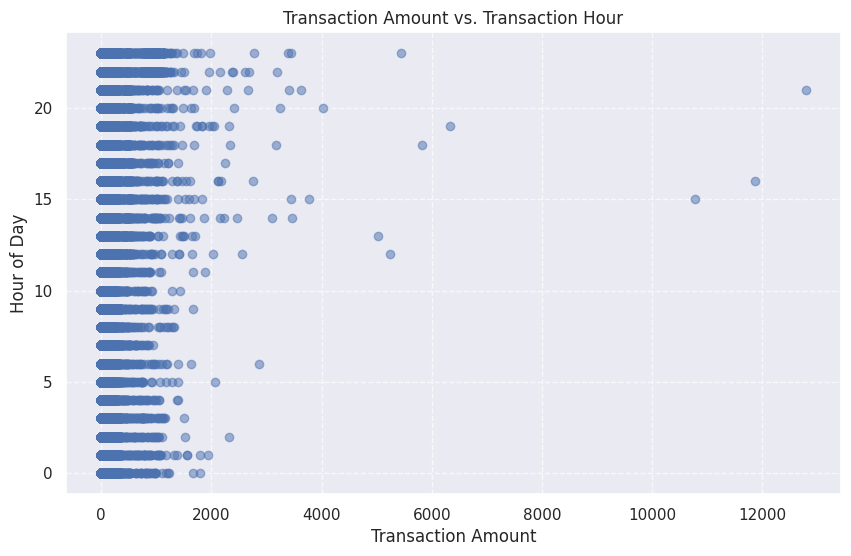

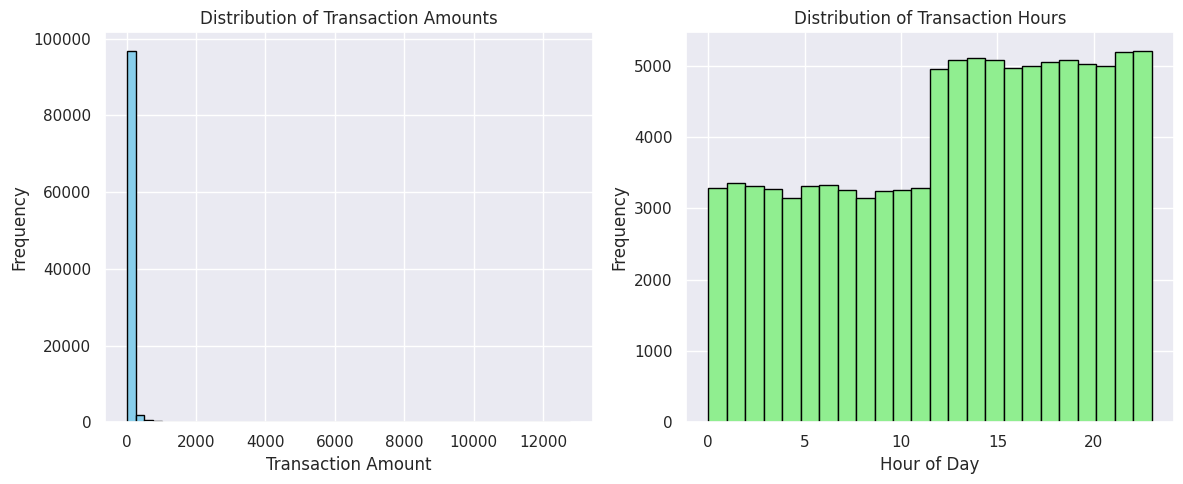

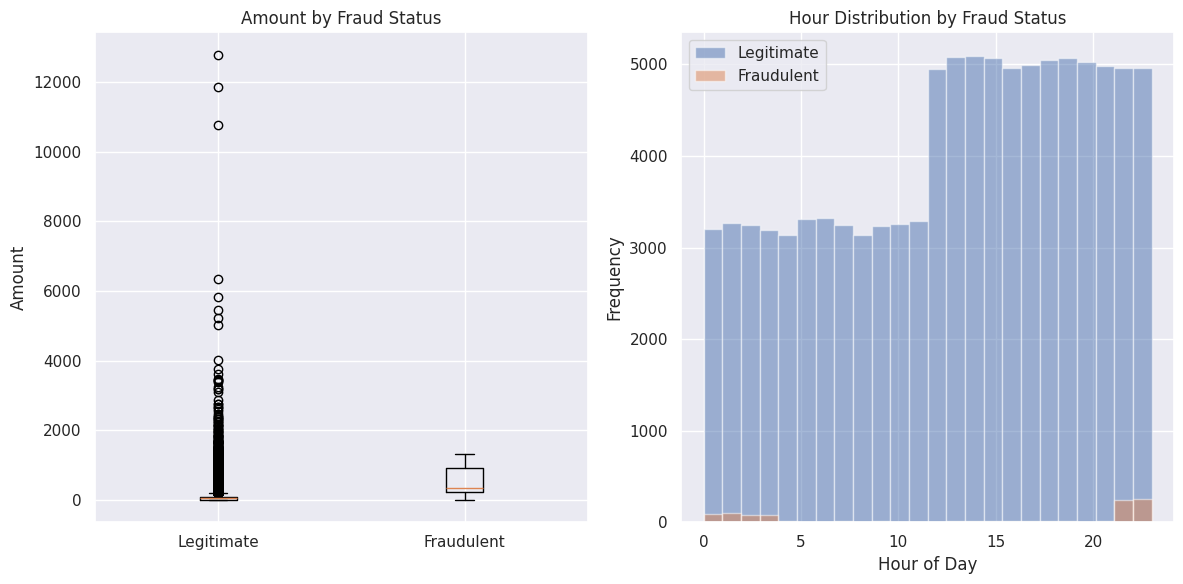

In [ ]:
# Create scatter plot to visualize transaction patterns
plt.figure(figsize=(10, 6))
plt.scatter(data['amt'], data['transaction_hour'], alpha=0.5)
plt.title('Transaction Amount vs. Transaction Hour')
plt.xlabel('Transaction Amount')
plt.ylabel('Hour of Day')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# #added during screencast
# Histogram of transaction amounts
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data['amt'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Histogram of transaction hours
plt.subplot(1, 2, 2)
plt.hist(data['transaction_hour'], bins=24, color='lightgreen', edgecolor='black')
plt.title('Distribution of Transaction Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# #added during screencast
# Compare amounts for fraudulent vs legitimate transactions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot([data[data['is_fraud']==0]['amt'], data[data['is_fraud']==1]['amt']])
plt.title('Amount by Fraud Status')
plt.xticks([1, 2], ['Legitimate', 'Fraudulent'])
plt.ylabel('Amount')

# Compare transaction hour distribution
plt.subplot(1, 2, 2)
for fraud_status in [0, 1]:
    plt.hist(data[data['is_fraud']==fraud_status]['transaction_hour'],
             bins=24, alpha=0.5,
             label=f"{'Fraudulent' if fraud_status else 'Legitimate'}")
plt.title('Hour Distribution by Fraud Status')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Anomaly Detection with Isolation Forest in Python

##Step 1: Implementing Anomaly Detection with Isolation Forest

In [ ]:
# Select features for anomaly detection
features = data[['amt', 'transaction_hour']]

# Initialize and train the Isolation Forest model
# Contamination parameter represents the expected proportion of anomalies
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(features)

# Predict anomaly scores and add to dataframe
# -1 for outliers and 1 for inliers
data['iso_score'] = model.predict(features)

# Convert predictions to binary classification (0 for normal, 1 for anomaly)
data['iso_anomaly'] = np.where(data['iso_score'] == -1, 1, 0)

# #added during screencast
# Display summary of detected anomalies
print(f"\nIsolation Forest - Number of anomalies detected: {data['iso_anomaly'].sum()}")
print(f"Isolation Forest - Percentage of transactions flagged as anomalies: {data['iso_anomaly'].mean() * 100:.2f}%")

# Compare with actual fraud cases
iso_fraud = data[(data['iso_anomaly'] == 1) & (data['is_fraud'] == 1)]
print(f"\nNumber of frauds identified by Isolation Forest: {len(iso_fraud)}")
print(f"Percentage of frauds caught: {len(iso_fraud) / data['is_fraud'].sum() * 100:.2f}%")
print(f"Precision (% of anomalies that are actual frauds): {len(iso_fraud) / data['iso_anomaly'].sum() * 100:.2f}%")


Isolation Forest - Number of anomalies detected: 1000
Isolation Forest - Percentage of transactions flagged as anomalies: 1.00%

Number of frauds identified by Isolation Forest: 464
Percentage of frauds caught: 46.87%
Precision (% of anomalies that are actual frauds): 46.40%


##Step 2: Evaluating and Visualizing Anomalies

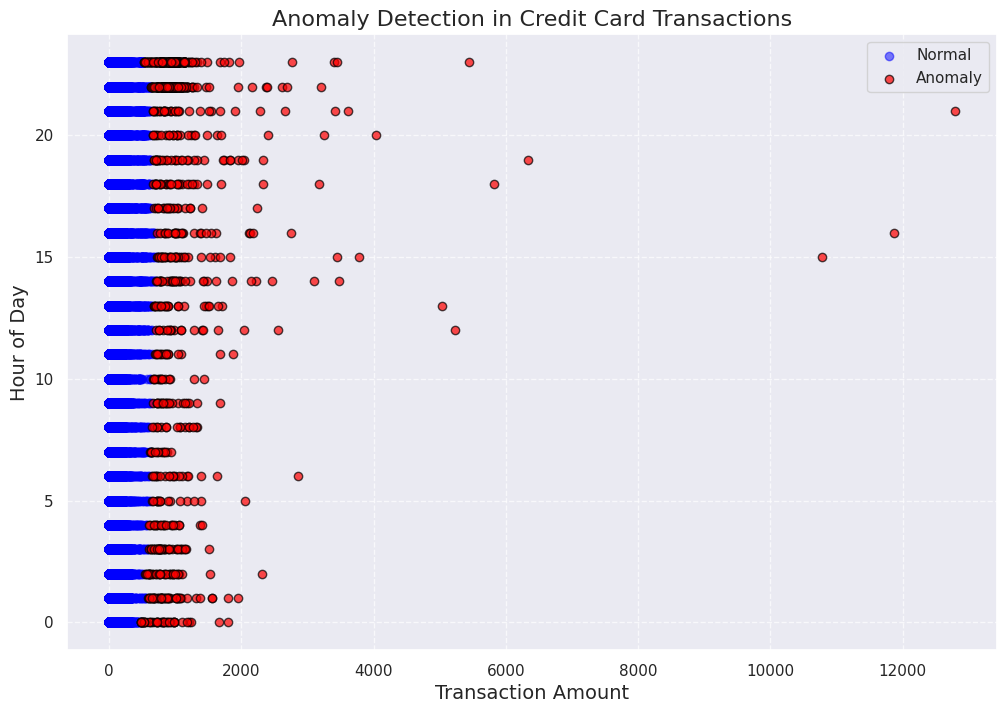

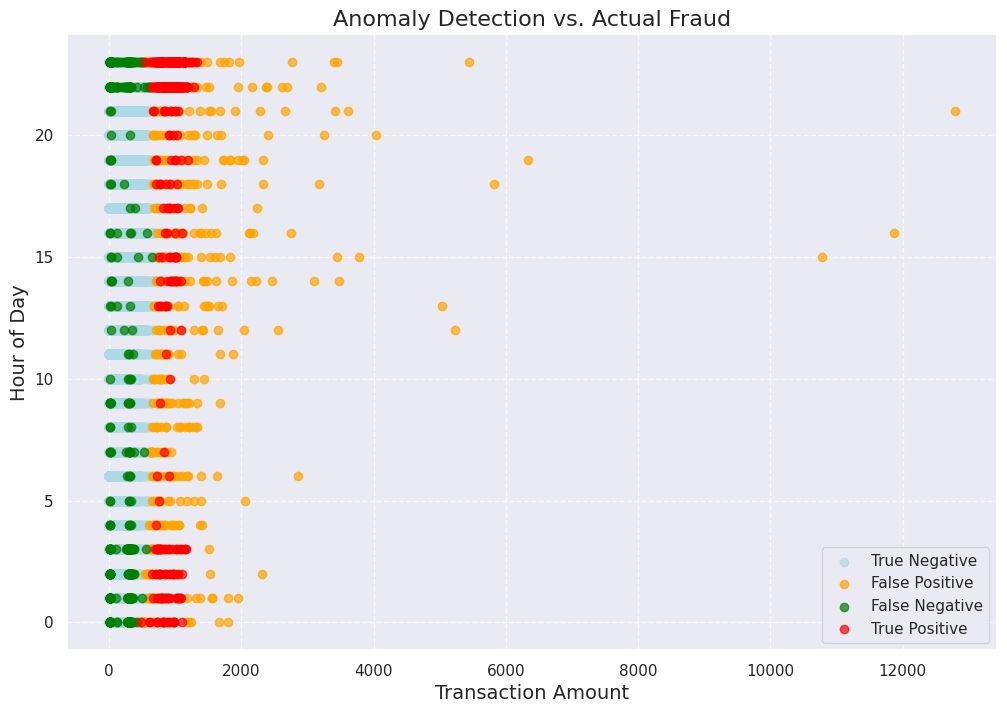


Statistics for normal transactions:
                amt  transaction_hour
count  99000.000000      99000.000000
mean      61.961405         12.777899
std       71.558369          6.806654
min        1.000000          0.000000
25%        9.620000          7.000000
50%       47.480000         14.000000
75%       82.402500         19.000000
max      719.260000         23.000000

Statistics for anomalous transactions:
                amt  transaction_hour
count   1000.000000       1000.000000
mean    1056.644090         15.081000
std      801.707061          8.089492
min      478.560000          0.000000
25%      764.760000          8.000000
50%      909.390000         18.000000
75%     1067.730000         22.000000
max    12788.070000         23.000000


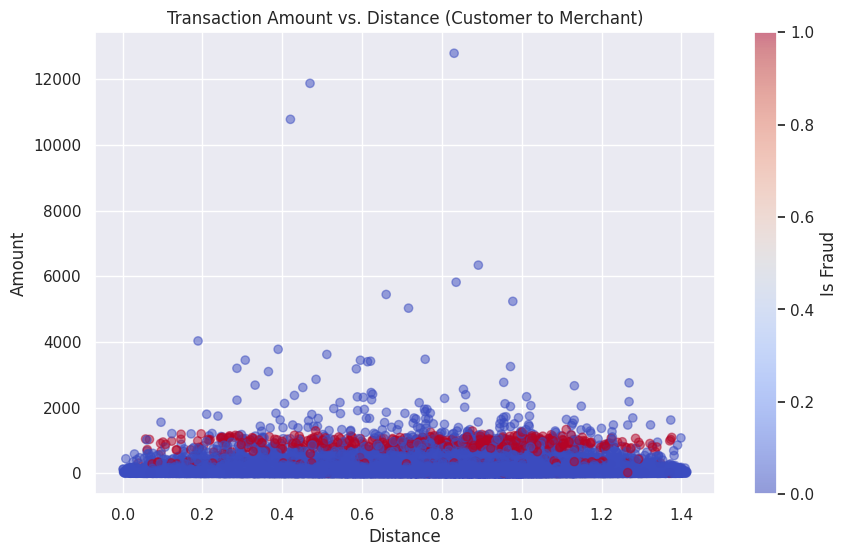

In [ ]:
# Visualize detected anomalies
plt.figure(figsize=(12, 8))
# Plot normal transactions
normal = data[data['iso_anomaly'] == 0]
plt.scatter(normal['amt'], normal['transaction_hour'],
            c='blue', label='Normal', alpha=0.5)

# Plot anomalies
anomalies = data[data['iso_anomaly'] == 1]
plt.scatter(anomalies['amt'], anomalies['transaction_hour'],
            c='red', label='Anomaly', alpha=0.7, edgecolors='black')

plt.title('Anomaly Detection in Credit Card Transactions', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Hour of Day', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# #added during screencast
# Compare detected anomalies with actual fraud
plt.figure(figsize=(12, 8))
# Four categories: true negatives, false positives, false negatives, true positives
colors = ['lightblue', 'orange', 'green', 'red']
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

for i, (fraud, anomaly) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    subset = data[(data['is_fraud'] == fraud) & (data['iso_anomaly'] == anomaly)]
    plt.scatter(subset['amt'], subset['transaction_hour'],
                c=colors[i], label=labels[i], alpha=0.7)

plt.title('Anomaly Detection vs. Actual Fraud', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Hour of Day', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Analyze characteristics of detected anomalies
print("\nStatistics for normal transactions:")
print(normal[['amt', 'transaction_hour']].describe())

print("\nStatistics for anomalous transactions:")
print(anomalies[['amt', 'transaction_hour']].describe())

# #added during screencast
# Additional features that might improve detection
# Calculate distance between customer and merchant
data['distance'] = np.sqrt((data['lat'] - data['merch_lat'])**2 +
                           (data['long'] - data['merch_long'])**2)

# Visualize distance vs amount
plt.figure(figsize=(10, 6))
plt.scatter(data['distance'], data['amt'], c=data['is_fraud'],
            cmap='coolwarm', alpha=0.5)
plt.title('Transaction Amount vs. Distance (Customer to Merchant)')
plt.xlabel('Distance')
plt.ylabel('Amount')
plt.colorbar(label='Is Fraud')
plt.show()